<a href="https://www.kaggle.com/code/matheustagomori/chuva-na-austr-lia?scriptVersionId=208844598" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Introdução
Este dataset consiste na observação de 10 anos de [dados climáticos diários](http://www.bom.gov.au/climate/data) de diversos locais da Austrália.

O Objetivo deste trabalho é prever se choverá ou não no dia seguinte. Para isto, serão utilizados e comparados diferentes modelos de classificação.

## Importando bibliotecas necessárias

In [61]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer, MinMaxScaler, OneHotEncoder, StandardScaler, LabelEncoder

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/weather-dataset-rattle-package/weatherAUS.csv


## Importando os dados

In [62]:
df = pd.read_csv('../input/weather-dataset-rattle-package/weatherAUS.csv')
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


## Explicando as variáveis

[Fonte](http://www.bom.gov.au/climate/dwo/IDCJDW0000.shtml)

1. Date = Data
2. Location = Cidade da Austrália
3. MinTemp = Temperatura mínima (graus Celsius)
4. MaxTemp = Temperatura máxima (graus Celsius)
5. Rainfall = Precipitação (ml)
6. Evaporation = ["Class A" pan evaporation](https://en.wikipedia.org/wiki/Pan_evaporation), padrão americano que mede a evaporação de água (ml)
7. Sunshine = Horas de luz solar
8. WindGustDir = Direção da rajada de vento mais forte (16 pontos da rosa dos ventos)
9. WindGustSpeed = Velocidade da rajada de vento mais forte (km/h)
10. WindDir9am = Direção da rajada de vento mais forte às 9am (pontos da rosa dos ventos)
11. WindDir3pm = Direção da rajada de vento mais forte às 3pm (pontos da rosa dos ventos)
12. WindSpeed9am = Velocidade da rajada de vento mais forte às 9am (km/h)
13. WindSpeed3pm = Velocidade da rajada de vento mais forte às 3pm (km/h)
14. Humidity9am = Umidade Relativa às 9am (%)
15. Humidity3pm = Umidade Relativa às 3pm (%)
16. Pressure9am = Pressão Atmosférica às 9am (hPa)
17. Pressure3pm = Pressão Atmosférica às 3pm (hPa)
18. Cloud9am = Fração nublada do céu às 9am (oitavos)
19. Cloud3pm = Fração nublada do céu às 3pm (oitavos)
20. Temp9am = Temperatura às 9am (graus Celsius)
21. Temp3pm = Temperatura às 3pm (graus Celsius)
22. RainToday = Se choveu ou não no dia
23. RainTomorrow = Variável alvo




# Análise Exploratória dos Dados (EDA)

In [63]:
print('Número de registros =',len(df['RainTomorrow']))
print('Número de variáveis =',len(df.columns)-1)

Número de registros = 145460
Número de variáveis = 22


In [64]:
df.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,143975.000000,144199.000000,142199.000000,82670.000000,75625.000000,135197.000000,143693.000000,142398.000000,142806.000000,140953.000000,130395.00000,130432.000000,89572.000000,86102.000000,143693.000000,141851.00000
mean,12.194034,23.221348,2.360918,5.468232,7.611178,40.035230,14.043426,18.662657,68.880831,51.539116,1017.64994,1015.255889,4.447461,4.509930,16.990631,21.68339
std,6.398495,7.119049,8.478060,4.193704,3.785483,13.607062,8.915375,8.809800,19.029164,20.795902,7.10653,7.037414,2.887159,2.720357,6.488753,6.93665
min,-8.500000,-4.800000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.50000,977.100000,0.000000,0.000000,-7.200000,-5.40000
25%,7.600000,17.900000,0.000000,2.600000,4.800000,31.000000,7.000000,13.000000,57.000000,37.000000,1012.90000,1010.400000,1.000000,2.000000,12.300000,16.60000
50%,12.000000,22.600000,0.000000,4.800000,8.400000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.60000,1015.200000,5.000000,5.000000,16.700000,21.10000
75%,16.900000,28.200000,0.800000,7.400000,10.600000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.40000,1020.000000,7.000000,7.000000,21.600000,26.40000
max,33.900000,48.100000,371.000000,145.000000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.00000,1039.600000,9.000000,9.000000,40.200000,46.70000


In [65]:
# Plota gráfico com porcentagem de valores nulos por coluna
fig = px.bar(df.isnull().mean()*100, title='Quantidade de Valores nulos por coluna (%)')
fig.show()

## Variáveis categoricas

In [66]:
s = (df.dtypes == "object")
cathegorical_variables = list(s[s].index)
df[cathegorical_variables].describe()

,Date,Location,WindGustDir,WindDir9am,WindDir3pm,RainToday,RainTomorrow
count,145460,145460,135134,134894,141232,142199,142193
unique,3436,49,16,16,16,2,2
top,2014-03-08,Canberra,W,N,SE,No,No
freq,49,3436,9915,11758,10838,110319,110316


1. Location: 49 únicos (49 cidades)
2. Wind: Posiçoes cardeais e subcolaterais

## Variáveis quantitativas

In [67]:
s = (df.dtypes == "float64")
numeric_variables = list(s[s].index)
print(numeric_variables)

['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm']


## Visualizações

Text(0.5, 0.98, 'Variável Alvo')

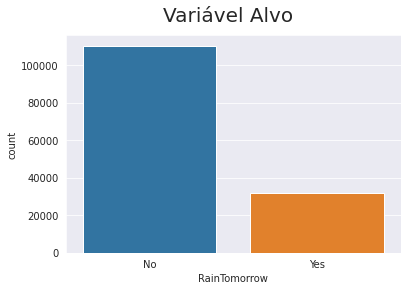

In [68]:
sns.countplot(x = df['RainTomorrow'])
plt.suptitle('Variável Alvo', fontsize= 20)

<AxesSubplot:xlabel='RainToday', ylabel='count'>

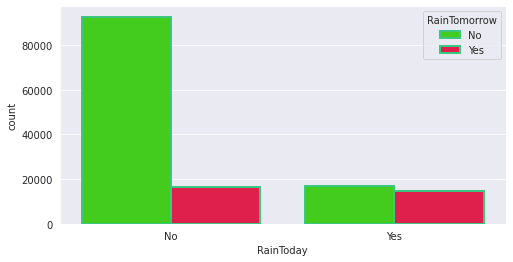

In [69]:
plt.figure(figsize = (8,4))
sns.countplot(x = 'RainToday', hue = 'RainTomorrow', data = df,
             edgecolor=(.23,.78,.5), linewidth = 2, palette="prism")

Como podemos ver, estamos tratando de dados desbalanceados

<AxesSubplot:xlabel='WindDir3pm', ylabel='count'>

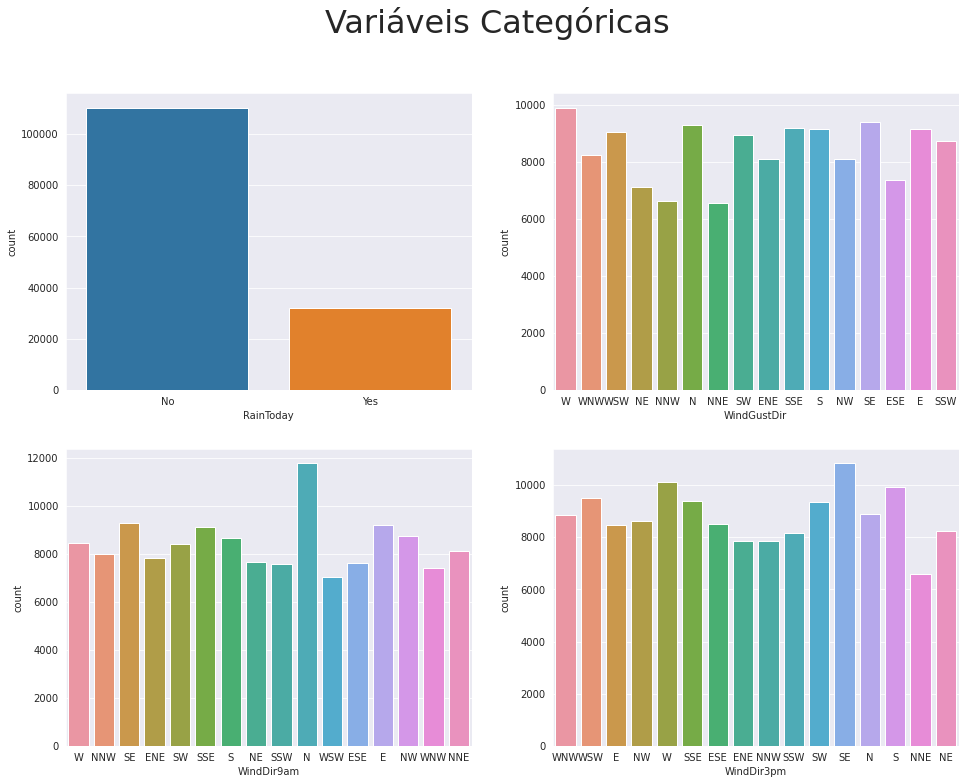

In [70]:
fig, axs = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Variáveis Categóricas', fontsize = 32)

sns.countplot(ax = axs[0][0], x = df['RainToday'])
sns.countplot(ax = axs[0][1], x = df['WindGustDir'])
sns.countplot(ax = axs[1][0], x = df['WindDir9am'])
sns.countplot(ax = axs[1][1], x = df['WindDir3pm'])

In [71]:
box_data = df[numeric_variables]
box_data.columns

Index(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm'],
      dtype='object')

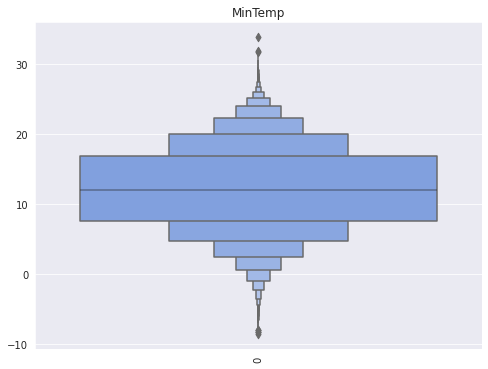

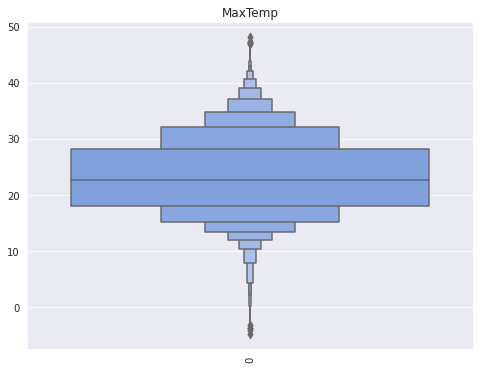

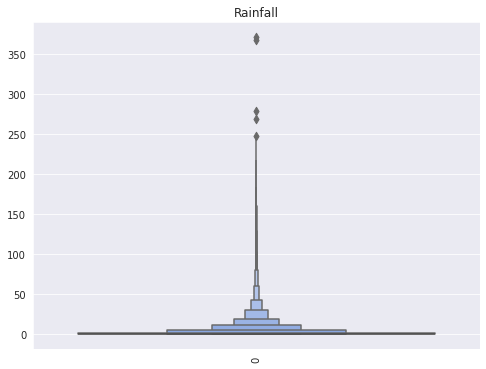

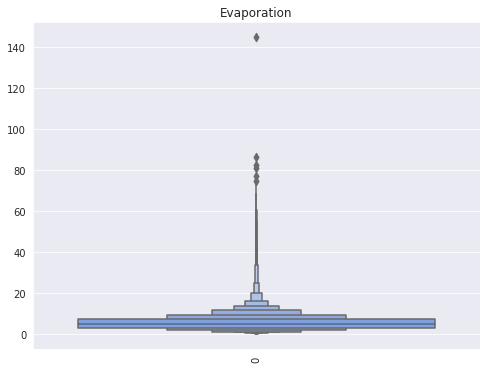

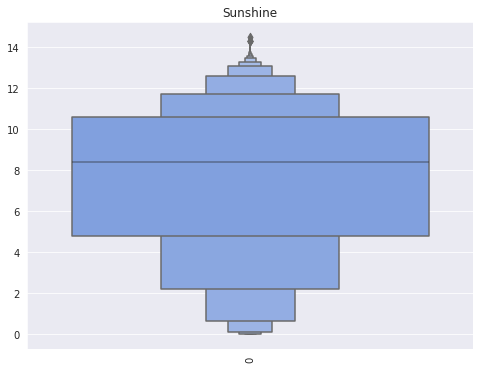

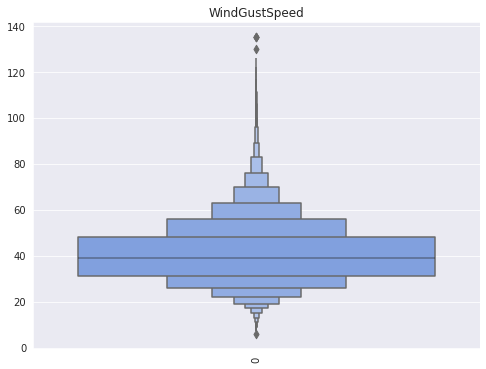

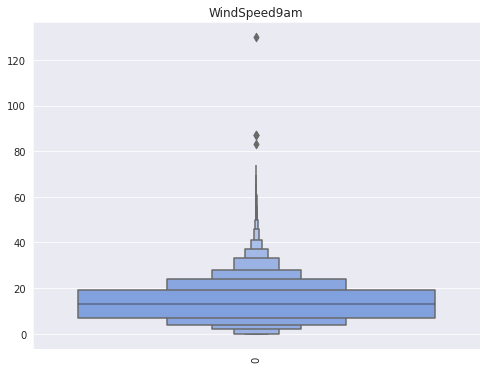

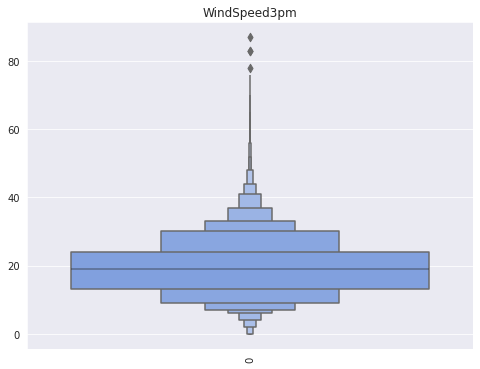

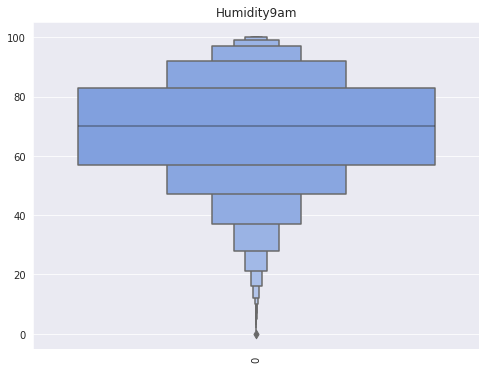

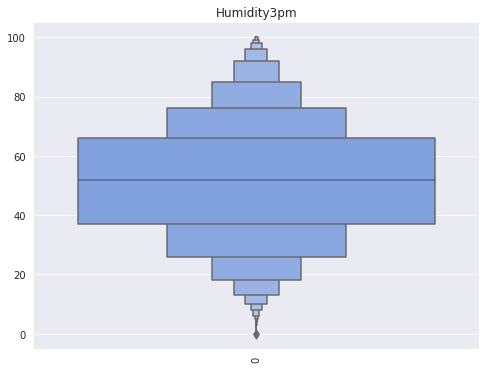

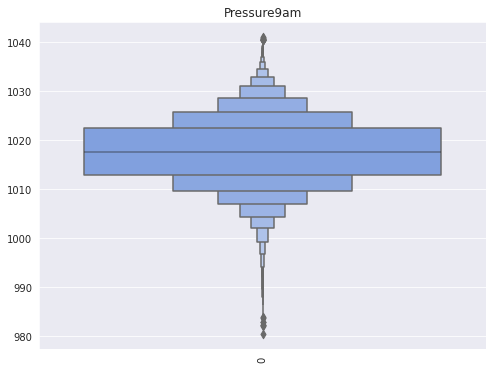

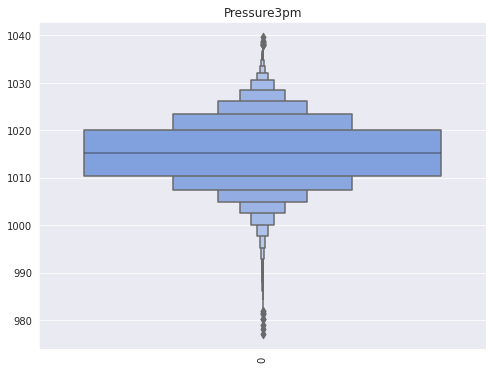

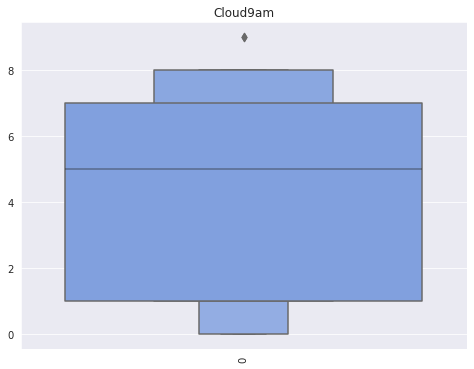

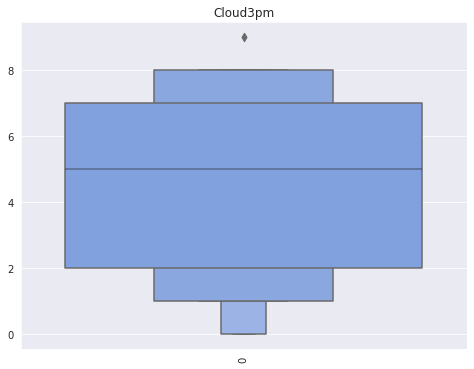

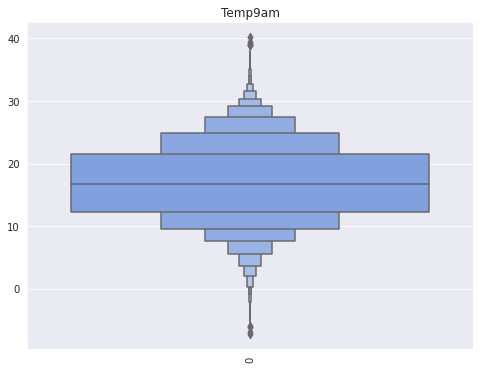

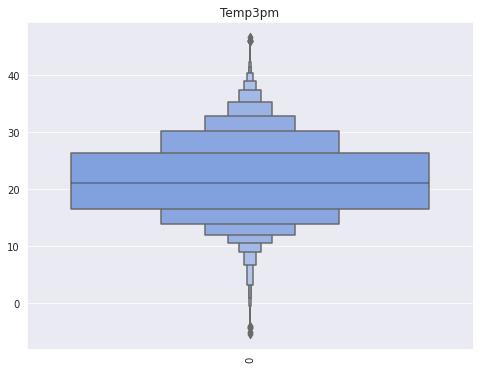

In [72]:
box_data = df[numeric_variables]

for col in box_data.columns:
    plt.figure(figsize=(8,6))
    sns.boxenplot(data = box_data[col], color='#729BED')
    plt.xticks(rotation=90)
    plt.title(col)
    plt.show()

### Histogramas
**Escala log aplicada em Rainfall, Evaporation, Sunshine, WindSpeed9am, Cloud9am e Cloud3pm**

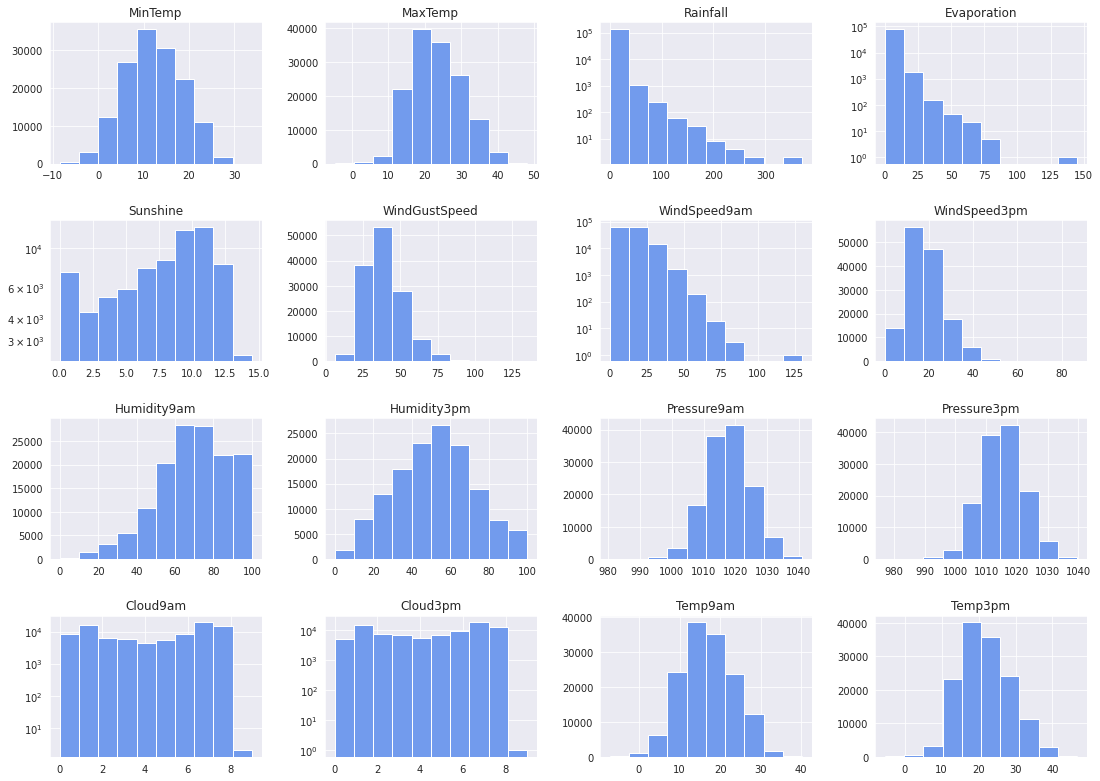

In [73]:
fig, axs = plt.subplots(4, 4, figsize=(16, 12))

axs[0][0].hist(df['MinTemp'], color = '#729BED')
axs[0][0].set_title('MinTemp')

axs[0][1].hist(df['MaxTemp'], color = '#729BED')
axs[0][1].set_title('MaxTemp')

axs[0][2].hist(df['Rainfall'], log = True, color = '#729BED')
axs[0][2].set_title('Rainfall')

axs[0][3].hist(df['Evaporation'], log = True, color = '#729BED')
axs[0][3].set_title('Evaporation')

axs[1][0].hist(df['Sunshine'], log = True, color = '#729BED')
axs[1][0].set_title('Sunshine')

axs[1][1].hist(df['WindGustSpeed'], color = '#729BED')
axs[1][1].set_title('WindGustSpeed')

axs[1][2].hist(df['WindSpeed9am'], log = True, color = '#729BED')
axs[1][2].set_title('WindSpeed9am')

axs[1][3].hist(df['WindSpeed3pm'], color = '#729BED')
axs[1][3].set_title('WindSpeed3pm')

axs[2][0].hist(df['Humidity9am'], color = '#729BED')
axs[2][0].set_title('Humidity9am')

axs[2][1].hist(df['Humidity3pm'], color = '#729BED')
axs[2][1].set_title('Humidity3pm')

axs[2][2].hist(df['Pressure9am'], color = '#729BED')
axs[2][2].set_title('Pressure9am')

axs[2][3].hist(df['Pressure3pm'], color = '#729BED')
axs[2][3].set_title('Pressure3pm')

axs[3][0].hist(df['Cloud9am'], log = True, color = '#729BED')
axs[3][0].set_title('Cloud9am')

axs[3][1].hist(df['Cloud3pm'], log = True, color = '#729BED')
axs[3][1].set_title('Cloud3pm')

axs[3][2].hist(df['Temp9am'], color = '#729BED')
axs[3][2].set_title('Temp9am')

axs[3][3].hist(df['Temp3pm'], color = '#729BED')
axs[3][3].set_title('Temp3pm')

fig.subplots_adjust(left=0.08, right=0.98, bottom=0.05, top=0.9,
                    hspace=0.4, wspace=0.3)

# Pré-processamento de dados

### Date
Separando Date em Year, Month e Day.

In [74]:
df['Date'] = pd.to_datetime(df['Date'])

df['Year'] = df['Date'].dt.year
print(df['Year'].head())

df['Month'] = df['Date'].dt.month
print(df['Month'].head())

df['Day'] = df['Date'].dt.day
print(df['Day'].head())

0    2008
1    2008
2    2008
3    2008
4    2008
Name: Year, dtype: int64
0    12
1    12
2    12
3    12
4    12
Name: Month, dtype: int64
0    1
1    2
2    3
3    4
4    5
Name: Day, dtype: int64


In [75]:
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Year,Month,Day
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,1007.1,8.0,NaN,16.9,21.8,No,No,2008,12,1
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,1007.8,NaN,NaN,17.2,24.3,No,No,2008,12,2
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,1008.7,NaN,2.0,21.0,23.2,No,No,2008,12,3
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,1012.8,NaN,NaN,18.1,26.5,No,No,2008,12,4
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,1006.0,7.0,8.0,17.8,29.7,No,No,2008,12,5


## Substituindo valores ausentes

### Variáveis Categóricas

Substituindo valores ausentes nas variáveis categóricas pela moda

In [76]:
null_cathegorical_variables = ['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']
for col in null_cathegorical_variables:
    df[col].fillna(df[col].mode()[0], inplace= True)

### Variáveis Numéricas
Substituindo valores ausentes em variáveis numéricas pela mediana

In [77]:
for col in numeric_variables:
    df[col].fillna(df[col].median(), inplace= True)
    
df.isnull().sum()

Date             0
Location         0
MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustDir      0
WindGustSpeed    0
WindDir9am       0
WindDir3pm       0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
RainToday        0
RainTomorrow     0
Year             0
Month            0
Day              0
dtype: int64

In [78]:
# Cópia de df para visualização
data = df.copy()

In [79]:
data.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Year,Month,Day
0,2008-12-01,Albury,13.4,22.9,0.6,4.8,8.4,W,44.0,W,...,1007.1,8.0,5.0,16.9,21.8,No,No,2008,12,1
1,2008-12-02,Albury,7.4,25.1,0.0,4.8,8.4,WNW,44.0,NNW,...,1007.8,5.0,5.0,17.2,24.3,No,No,2008,12,2
2,2008-12-03,Albury,12.9,25.7,0.0,4.8,8.4,WSW,46.0,W,...,1008.7,5.0,2.0,21.0,23.2,No,No,2008,12,3
3,2008-12-04,Albury,9.2,28.0,0.0,4.8,8.4,NE,24.0,SE,...,1012.8,5.0,5.0,18.1,26.5,No,No,2008,12,4
4,2008-12-05,Albury,17.5,32.3,1.0,4.8,8.4,W,41.0,ENE,...,1006.0,7.0,8.0,17.8,29.7,No,No,2008,12,5


## Codificação de variáveis categóricas

### Variáveis Binárias

In [80]:
lb = LabelBinarizer()

# Transforma variáveis Yes e No em 1 e 0
df['RainToday'] = lb.fit_transform(df['RainToday'])
df['RainTomorrow'] = lb.fit_transform(df['RainTomorrow'])

<AxesSubplot:>

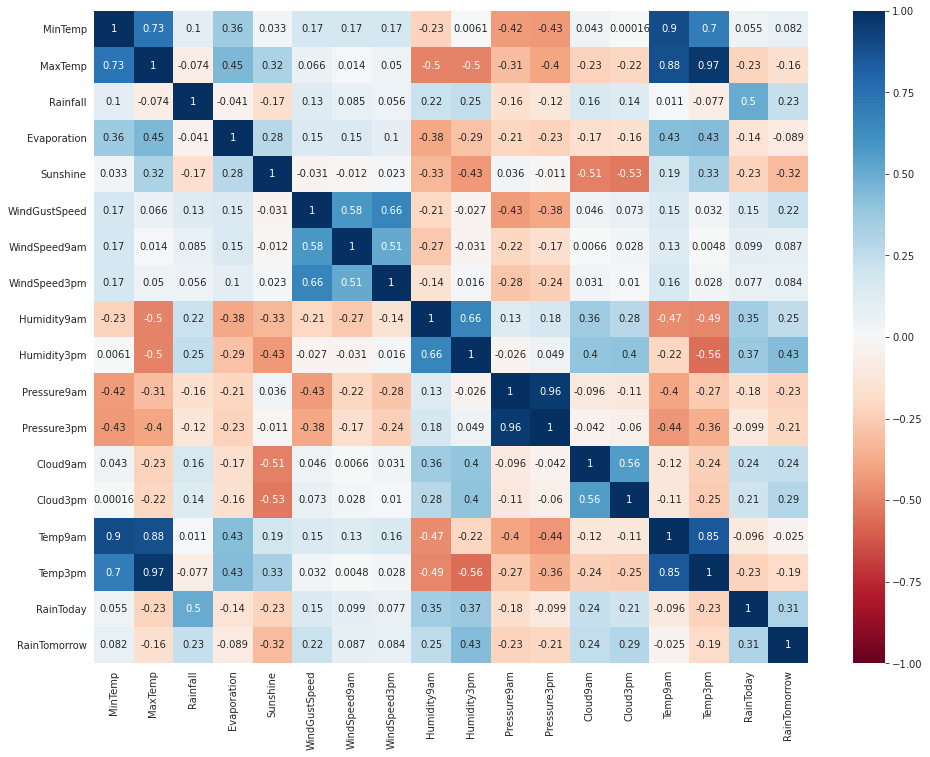

In [81]:
corr = df.drop(columns = ['Date', 'Year', 'Month', 'Day']).corr()
plt.subplots(figsize=(16,12))
sns.heatmap(corr, annot=True, cmap = 'RdBu', vmin=-1)

### One-Hot Encoding

In [82]:
# Cria colunas para cada direção. A linha de cada direção terá o valor 1 na coluna da respectiva direção.
for col in ['WindGustDir', 'WindDir9am', 'WindDir3pm']:
    df = pd.concat([df, pd.get_dummies(df[col])], axis=1)
    directions = {'E': col + '_E', 
     'ENE': col + '_ENE', 
     'ESE': col + '_ESE', 
     'N': col + '_N', 
     'NE': col + '_NE', 
     'NNE': col + '_NNE',
     'NNW': col + '_NNW',
     'NW': col + '_NW',
     'S': col + '_S',
     'SE': col + '_SE',
     'SSE': col + '_SSE',
     'SSW': col + '_SSW',
     'SW': col + '_SW',
     'W': col + '_W',
     'WNW': col + '_WNW',
     'WSW': col + '_WSW',
    }
    
    df.rename(columns = directions, inplace = True)

for col in df.columns:
    print (col)

Date
Location
MinTemp
MaxTemp
Rainfall
Evaporation
Sunshine
WindGustDir
WindGustSpeed
WindDir9am
WindDir3pm
WindSpeed9am
WindSpeed3pm
Humidity9am
Humidity3pm
Pressure9am
Pressure3pm
Cloud9am
Cloud3pm
Temp9am
Temp3pm
RainToday
RainTomorrow
Year
Month
Day
WindGustDir_E
WindGustDir_ENE
WindGustDir_ESE
WindGustDir_N
WindGustDir_NE
WindGustDir_NNE
WindGustDir_NNW
WindGustDir_NW
WindGustDir_S
WindGustDir_SE
WindGustDir_SSE
WindGustDir_SSW
WindGustDir_SW
WindGustDir_W
WindGustDir_WNW
WindGustDir_WSW
WindDir9am_E
WindDir9am_ENE
WindDir9am_ESE
WindDir9am_N
WindDir9am_NE
WindDir9am_NNE
WindDir9am_NNW
WindDir9am_NW
WindDir9am_S
WindDir9am_SE
WindDir9am_SSE
WindDir9am_SSW
WindDir9am_SW
WindDir9am_W
WindDir9am_WNW
WindDir9am_WSW
WindDir3pm_E
WindDir3pm_ENE
WindDir3pm_ESE
WindDir3pm_N
WindDir3pm_NE
WindDir3pm_NNE
WindDir3pm_NNW
WindDir3pm_NW
WindDir3pm_S
WindDir3pm_SE
WindDir3pm_SSE
WindDir3pm_SSW
WindDir3pm_SW
WindDir3pm_W
WindDir3pm_WNW
WindDir3pm_WSW


In [83]:
# Remove WindGustDir, WindDir9am and WindDir3pm
df = df.drop(['WindGustDir', 'WindDir9am', 'WindDir3pm'], axis=1)

## Remoção de outliers

### Cloud3pm e Cloud9am
Alguns valores = 9.0, o que é incoerente, visto que os valores de Cloud são em oitavos. 9/8 indicaria mais de 100% do céu nublado.

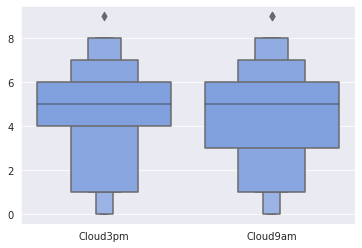

In [84]:
sns.boxenplot(data = df[['Cloud3pm', 'Cloud9am']], color='#729BED')
plt.show()

In [85]:
def max_value(df3, variable, top):
    return np.where(df3[variable]>top, top, df3[variable])

df['Cloud3pm'] = max_value(df, 'Cloud3pm', 8.0)
df['Cloud9am'] = max_value(df, 'Cloud9am', 8.0)
df.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,WindDir3pm_NNW,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW
count,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,...,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000
mean,12.192053,23.215962,2.307990,5.179779,7.989889,39.962189,14.030751,18.669758,68.901251,51.553396,...,0.054104,0.059192,0.068239,0.103575,0.064616,0.056070,0.064306,0.069504,0.061006,0.065434
std,6.365780,7.088358,8.389771,3.178819,2.757790,13.120931,8.861796,8.716716,18.855360,20.471345,...,0.226224,0.235984,0.252156,0.304709,0.245847,0.230058,0.245299,0.254310,0.239343,0.247291
min,-8.500000,-4.800000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.700000,18.000000,0.000000,4.000000,8.200000,31.000000,7.000000,13.000000,57.000000,37.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,12.000000,22.600000,0.000000,4.800000,8.400000,39.000000,13.000000,19.000000,70.000000,52.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,16.800000,28.200000,0.600000,5.200000,8.700000,46.000000,19.000000,24.000000,83.000000,65.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,33.900000,48.100000,371.000000,145.000000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


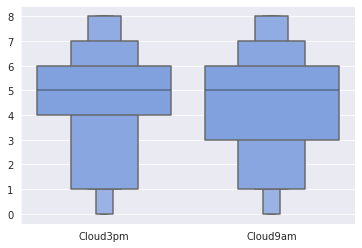

In [86]:
sns.boxenplot(data = df[['Cloud3pm', 'Cloud9am']], color='#729BED')
plt.show()

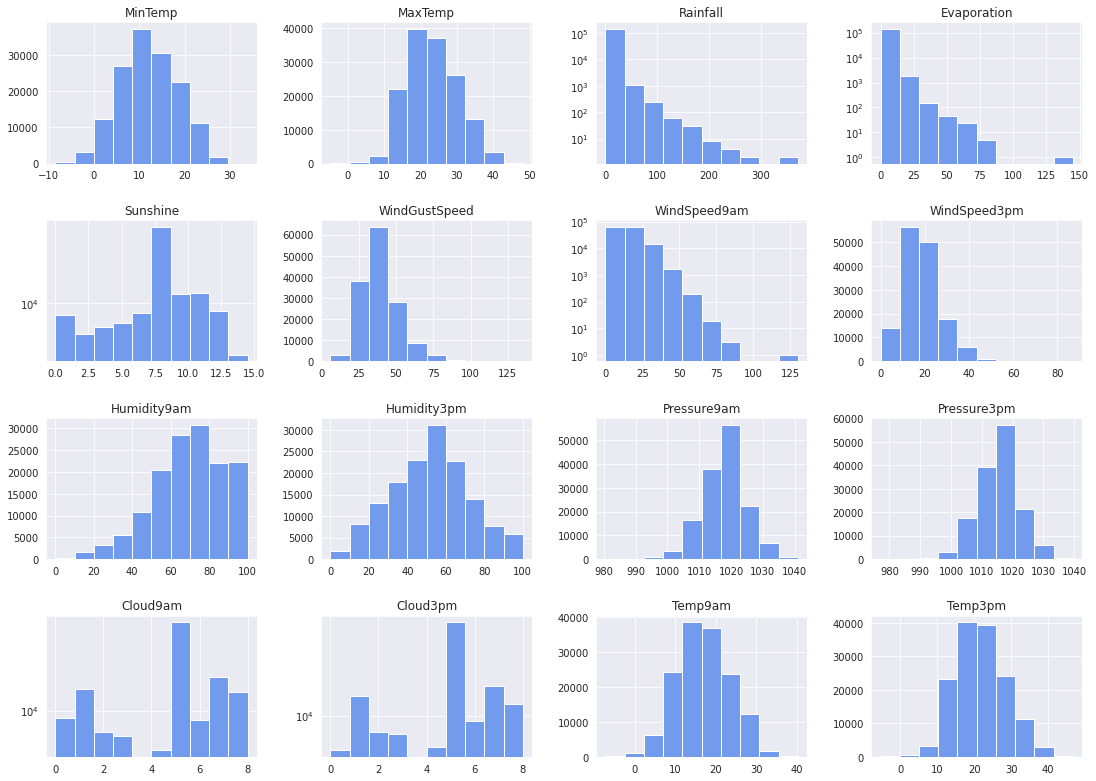

In [87]:
fig, axs = plt.subplots(4, 4, figsize=(16, 12))

axs[0][0].hist(df['MinTemp'], color = '#729BED')
axs[0][0].set_title('MinTemp')

axs[0][1].hist(df['MaxTemp'], color = '#729BED')
axs[0][1].set_title('MaxTemp')

axs[0][2].hist(df['Rainfall'], log = True, color = '#729BED')
axs[0][2].set_title('Rainfall')

axs[0][3].hist(df['Evaporation'], log = True, color = '#729BED')
axs[0][3].set_title('Evaporation')

axs[1][0].hist(df['Sunshine'], log = True, color = '#729BED')
axs[1][0].set_title('Sunshine')

axs[1][1].hist(df['WindGustSpeed'], color = '#729BED')
axs[1][1].set_title('WindGustSpeed')

axs[1][2].hist(df['WindSpeed9am'], log = True, color = '#729BED')
axs[1][2].set_title('WindSpeed9am')

axs[1][3].hist(df['WindSpeed3pm'], color = '#729BED')
axs[1][3].set_title('WindSpeed3pm')

axs[2][0].hist(df['Humidity9am'], color = '#729BED')
axs[2][0].set_title('Humidity9am')

axs[2][1].hist(df['Humidity3pm'], color = '#729BED')
axs[2][1].set_title('Humidity3pm')

axs[2][2].hist(df['Pressure9am'], color = '#729BED')
axs[2][2].set_title('Pressure9am')

axs[2][3].hist(df['Pressure3pm'], color = '#729BED')
axs[2][3].set_title('Pressure3pm')

axs[3][0].hist(df['Cloud9am'], log = True, color = '#729BED')
axs[3][0].set_title('Cloud9am')

axs[3][1].hist(df['Cloud3pm'], log = True, color = '#729BED')
axs[3][1].set_title('Cloud3pm')

axs[3][2].hist(df['Temp9am'], color = '#729BED')
axs[3][2].set_title('Temp9am')

axs[3][3].hist(df['Temp3pm'], color = '#729BED')
axs[3][3].set_title('Temp3pm')

fig.subplots_adjust(left=0.08, right=0.98, bottom=0.05, top=0.9,
                    hspace=0.4, wspace=0.3)

In [88]:
non_scalable_cols = ['Location', 'Day', 'Month', 'Year', 'Date', 'RainToday', 'RainTomorrow']

non_gaussian_cols = ['Rainfall', 'Evaporation', 'Sunshine', 'WindSpeed9am', 'Humidity9am', 'Cloud9am', 'Cloud3pm']

gaussian_cols = [col for col in df.columns if col not in(non_gaussian_cols)]

min_max_scaler = MinMaxScaler()
standard_scaler = StandardScaler()

# Criando copia de df
scaled_df = df.copy()

# Dropando colunas que não se aplicam e não gaussianas para MinMaxScaling, normalização apropriada para estas distribuições
dropping_min_max_cols = non_scalable_cols+non_gaussian_cols
scaled_df = df.drop(dropping_min_max_cols, axis= 1)
scaled_cols = scaled_df.columns

# Aplicando normalização minmax para colunas apropriadas
scaled_df = min_max_scaler.fit_transform(scaled_df)
scaled_df = pd.DataFrame(scaled_df, columns=scaled_cols)
df = pd.concat([scaled_df, df[dropping_min_max_cols]], axis= 1)

# Fazendo o mesmo para variáveis de distribuição gaussiana, porém com Standard Scaler
dropping_standard_cols = non_scalable_cols+non_gaussian_cols
scaled_df = df.drop(dropping_standard_cols, axis= 1)
scaled_cols = scaled_df.columns
scaled_df = standard_scaler.fit_transform(scaled_df)
scaled_df = pd.DataFrame(scaled_df, columns=scaled_cols)
df = pd.concat([scaled_df, df[dropping_standard_cols]], axis= 1)

## Ocorrência de chuva por ano

## Selecionando localidades
Como temos dados de 49 cidades e a Austrália é muito extensa geográficamente, serão selecionadas 3 cidades próximas umas das outras em busca de melhores previsões.

In [89]:
print('Location contains ', len(df['Location'].unique()),'labels')
print(df.Location.value_counts())
mainLocations = ['Sydney','Canberra','Newcastle']
mainData = df[df["Location"].isin(mainLocations)]
mainData.shape

Location contains  49 labels
Canberra            3436
Sydney              3344
Brisbane            3193
Hobart              3193
Perth               3193
Melbourne           3193
Adelaide            3193
Darwin              3193
Bendigo             3040
Albury              3040
MountGambier        3040
Cairns              3040
GoldCoast           3040
Ballarat            3040
AliceSprings        3040
MountGinini         3040
Townsville          3040
Albany              3040
Launceston          3040
Wollongong          3040
Newcastle           3039
Tuggeranong         3039
Penrith             3039
PearceRAAF          3009
Dartmoor            3009
Woomera             3009
SydneyAirport       3009
PerthAirport        3009
Nuriootpa           3009
Richmond            3009
Sale                3009
Moree               3009
Witchcliffe         3009
MelbourneAirport    3009
NorfolkIsland       3009
WaggaWagga          3009
BadgerysCreek       3009
Portland            3009
Mildura             3

(9819, 71)

Dentre as 5 localidades com mais medidas, foram escolhidas **Sydney**, **Canberra** e **Newcastle** por serem próximas geograficamente.
Agora temos 9819 registros.

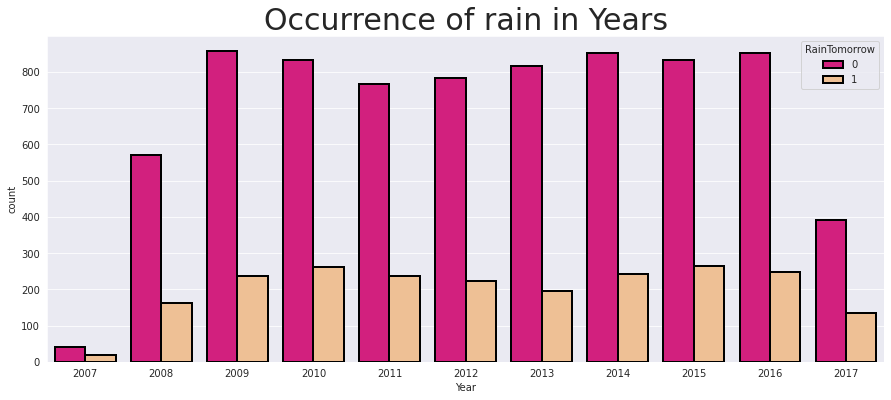

In [90]:
sns.set_style('darkgrid')
plt.figure(figsize=[15,6])
ax = sns.countplot(x = 'Year', hue = 'RainTomorrow',edgecolor=(0,0,0),
                  linewidth=2,
              palette="Accent_r", data = mainData)
ax.set_title( "Occurrence of rain in Years",size = 30 )
plt.show()

In [91]:
mainData.describe()

,MinTemp,MaxTemp,WindGustSpeed,WindSpeed3pm,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,WindGustDir_E,...,Year,RainToday,RainTomorrow,Rainfall,Evaporation,Sunshine,WindSpeed9am,Humidity9am,Cloud9am,Cloud3pm
count,9819.000000,9819.000000,9819.000000,9819.000000,9819.000000,9819.000000,9819.000000,9819.000000,9819.000000,9819.000000,...,9819.000000,9819.000000,9819.000000,9819.000000,9819.000000,9819.000000,9819.000000,9819.000000,9819.000000,9819.000000
mean,-0.085303,-0.087194,0.001624,-0.149486,0.017339,0.098128,0.084972,-0.139621,-0.106080,-0.084074,...,2012.387005,0.226703,0.226601,2.694327,4.855841,7.831765,10.863734,71.660963,4.488543,4.583359
std,0.998637,0.819581,0.757401,1.058375,0.833955,0.883142,0.870188,0.898952,0.801628,0.831208,...,2.726693,0.418720,0.418654,8.991907,2.067178,2.663109,8.897802,15.049766,2.642698,2.323687
min,-3.171980,-2.696820,-2.207335,-2.141841,-2.322933,-4.599086,-4.464322,-2.835527,-2.622956,-0.259556,...,2007.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000
25%,-0.689950,-0.665313,-0.073333,-0.879894,-0.515522,-0.170138,-0.202599,-0.757775,-0.623142,-0.259556,...,2010.000000,0.000000,0.000000,0.000000,4.200000,8.200000,4.000000,62.000000,2.000000,3.000000
50%,-0.030170,-0.086898,-0.073333,0.037886,0.021816,-0.006653,-0.007520,-0.060022,-0.083046,-0.259556,...,2012.000000,0.000000,0.000000,0.000000,4.800000,8.400000,9.000000,72.000000,5.000000,5.000000
75%,0.676737,0.449194,0.079096,0.382054,0.510305,0.513525,0.487680,0.529191,0.398661,-0.259556,...,2015.000000,0.000000,0.000000,0.800000,4.800000,8.400000,17.000000,82.000000,7.000000,6.000000
max,2.420442,3.186086,5.033030,7.380126,2.366565,3.411662,3.398857,3.025595,3.361891,3.852738,...,2017.000000,1.000000,1.000000,240.000000,20.000000,13.600000,130.000000,100.000000,8.000000,8.000000


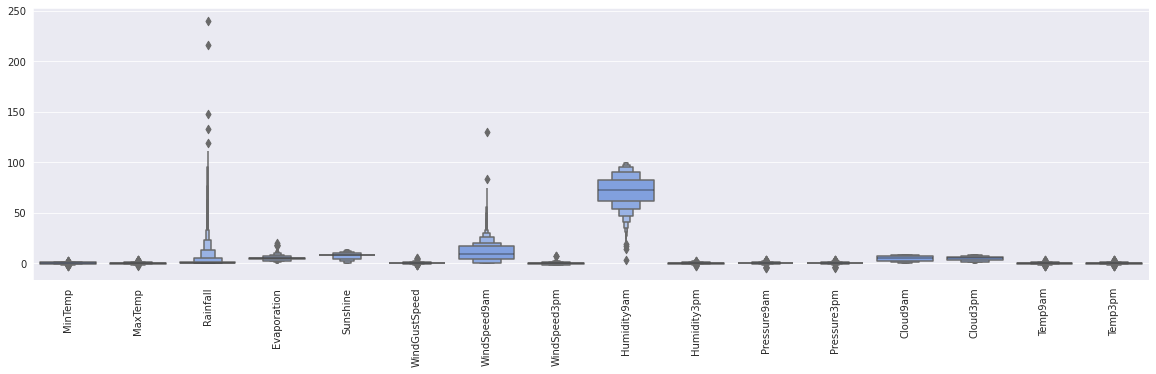

In [92]:
box_data = mainData[numeric_variables]

plt.figure(figsize=(20,5))
sns.boxenplot(data = box_data, color='#729BED')
plt.xticks(rotation=90)
plt.show()

In [93]:
mainData = mainData.reset_index(drop= True)
mainData.head()

,MinTemp,MaxTemp,WindGustSpeed,WindSpeed3pm,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,WindGustDir_E,...,Date,RainToday,RainTomorrow,Rainfall,Evaporation,Sunshine,WindSpeed9am,Humidity9am,Cloud9am,Cloud3pm
0,0.158339,-0.086898,-0.073333,0.037886,-1.345954,-0.006653,-0.00752,0.746270,1.303687,-0.259556,...,2008-12-01,0,0,0.0,4.8,8.4,6.0,50.0,3.0,4.0
1,-0.030170,1.267440,-0.073333,0.037886,0.363759,-0.006653,-0.00752,-0.044517,0.544633,-0.259556,...,2008-12-02,0,0,0.0,4.8,8.4,13.0,70.0,5.0,0.0
2,0.629610,1.267440,-0.073333,-1.912396,-1.248256,-0.006653,-0.00752,0.808292,1.508048,-0.259556,...,2008-12-03,0,0,0.0,4.8,8.4,2.0,74.0,4.0,4.0
3,1.100882,0.110610,-0.073333,0.382054,0.461457,-0.006653,-0.00752,0.529191,0.194301,-0.259556,...,2008-12-04,0,0,0.0,4.8,8.4,22.0,66.0,7.0,5.0
4,1.038046,0.985286,-0.073333,0.037886,0.021816,-0.006653,-0.00752,0.467168,-0.083046,-0.259556,...,2008-12-05,0,0,0.0,4.8,8.4,4.0,85.0,8.0,5.0


In [94]:
import plotly.express as px

df_sydney = data[data.Location == 'Sydney']

In [95]:
fig = px.scatter(df_sydney, 
                 x = 'Date', 
                 y = 'Temp3pm', 
                 color = 'RainToday',
                 title = 'Temperatura diária às 3PM',
                 labels = {'RainToday': 'Choveu'})

fig.update_layout(xaxis_title=None)

fig.show()

In [96]:
# Rainfall
fig = px.bar(df_sydney[df_sydney.Year == 2016],
                 x = 'Date', 
                 y = 'Rainfall', 
                 title = 'Temperatura diária às 3PM',
                 labels = {'RainToday': 'Choveu'})

fig.update_layout(xaxis_title=None)

fig.show()

# Modelos Preditivos

In [97]:
# Validação Cruzada
from sklearn.model_selection import cross_val_score, cross_validate

### Removendo colunas Location, Year, Day e Month

In [98]:
mainData.drop(['Location','Year','Day', 'Month', 'Date'], axis=1, inplace=True)

### Separação de dados de treino e teste
O conjunto de teste terá 33% dos dados e os dados serão embaralhados

In [99]:
from sklearn.model_selection import train_test_split
features = mainData.loc[:, mainData.columns != 'RainTomorrow'].values
target   = mainData.loc[:, mainData.columns == 'RainTomorrow'].values.ravel()
x_train, x_test, y_train, y_test = train_test_split(features, target, shuffle= True, test_size=0.33, random_state=42)

## Regressão Logística

### Otimizando hiperparâmetros

In [100]:
for i in range(-1, 5):
    
    c = 10**i
    
    clf = LogisticRegression(
        C=1000,
        solver= 'liblinear',
        random_state=0).fit(x_train, y_train)
    
    print('C= ', c, ' train score = ', clf.score(x_train, y_train))
    print('C= ', c, ' test score = ', clf.score(x_test, y_test), '\n')

C=  0.1  train score =  0.842809364548495
C=  0.1  test score =  0.8275223696390003 

C=  1  train score =  0.842809364548495
C=  1  test score =  0.8275223696390003 

C=  10  train score =  0.842809364548495
C=  10  test score =  0.8275223696390003 

C=  100  train score =  0.842809364548495
C=  100  test score =  0.8275223696390003 

C=  1000  train score =  0.842809364548495
C=  1000  test score =  0.8275223696390003 

C=  10000  train score =  0.842809364548495
C=  10000  test score =  0.8275223696390003 



Foram escolhidos os parâmetros C = 1000, penalty = 'l2' e solver= 'liblinear' por ter apresentado o mehor resultado no conjunto de teste

In [101]:
clfLR = LogisticRegression(
        C=1000,
        solver= 'liblinear',
        random_state=0)

clfLR.fit(x_train, y_train)

LogisticRegression(C=1000, random_state=0, solver='liblinear')

In [102]:
# Calcuma e printa métricas de desempenho
def print_scores(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')  # 'macro' para média ponderada entre as classes
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Exibindo os resultados
    print(f'\nAcurácia: {accuracy:.2f}. O modelo previu corretamente {accuracy*100:.2f}% dos casos em que chove no dia seguinte.')
    print(f'\nPrecisão: {precision:.2f}. {precision*100:.2f}% dos casos em que foi previsto que choveria no dia seguinte estavam corretos.')
    print(f'\nRecall: {recall:.2f}. Isto significa que {recall*100:.2f}% dos dias que choverá foram corretamente identificados.')
    print(f'\nF1-Score: {f1:.2f}.')
    print('\nMatriz de Confusão:')
    print(conf_matrix)

### Avaliação

In [103]:
y_pred = clfLR.predict(x_test)
print_scores(y_test, y_pred)


Acurácia: 0.83. O modelo previu corretamente 82.75% dos casos em que chove no dia seguinte.

Precisão: 0.78. 77.69% dos casos em que foi previsto que choveria no dia seguinte estavam corretos.

Recall: 0.69. Isto significa que 69.48% dos dias que choverá foram corretamente identificados.

F1-Score: 0.72.

Matriz de Confusão:
[[2345  141]
 [ 418  337]]


## Naive Bayes

In [104]:
naiveBayesClf = GaussianNB()

naiveBayesClf.fit(x_train, y_train)

y_pred = naiveBayesClf.predict(x_test)
    
print_scores(y_test, y_pred)


Acurácia: 0.74. O modelo previu corretamente 74.08% dos casos em que chove no dia seguinte.

Precisão: 0.65. 65.15% dos casos em que foi previsto que choveria no dia seguinte estavam corretos.

Recall: 0.67. Isto significa que 66.92% dos dias que choverá foram corretamente identificados.

F1-Score: 0.66.

Matriz de Confusão:
[[1997  489]
 [ 351  404]]


## Árvores de Decisão

In [105]:
decisionTreeClf = DecisionTreeClassifier()

parameters = dict(
                   criterion = ['gini'],
                   splitter = ['random'],
                   min_samples_leaf = [4],
                   max_features = ['auto'],
                   class_weight = [None]
                  )

decisionTreeClf = GridSearchCV(decisionTreeClf, parameters)
decisionTreeClf_Trained = decisionTreeClf.fit(x_train, y_train)

cv = cross_val_score(decisionTreeClf_Trained,features,target,cv=15,scoring='accuracy')
print('\nAcurácia média: %0.2f%% +- %0.2f%%'%(np.mean(cv)*100,np.std(cv)*100))

print('\nMelhor combinação de parâmetros encontrada:')
print(decisionTreeClf_Trained.best_params_)

y_pred = decisionTreeClf_Trained.predict(x_test)    

print_scores(y_test, y_pred)


Acurácia média: 78.83% +- 2.75%

Melhor combinação de parâmetros encontrada:
{'class_weight': None, 'criterion': 'gini', 'max_features': 'auto', 'min_samples_leaf': 4, 'splitter': 'random'}

Acurácia: 0.79. O modelo previu corretamente 79.42% dos casos em que chove no dia seguinte.

Precisão: 0.71. 71.03% dos casos em que foi previsto que choveria no dia seguinte estavam corretos.

Recall: 0.65. Isto significa que 65.00% dos dias que choverá foram corretamente identificados.

F1-Score: 0.67.

Matriz de Confusão:
[[2287  199]
 [ 468  287]]


### Random Forest

In [106]:
randomForestClf = RandomForestClassifier()

randomForestClf_Trained = randomForestClf.fit(x_train, y_train)

y_pred = randomForestClf_Trained.predict(x_test)

print_scores(y_test, y_pred)


Acurácia: 0.83. O modelo previu corretamente 83.37% dos casos em que chove no dia seguinte.

Precisão: 0.80. 80.36% dos casos em que foi previsto que choveria no dia seguinte estavam corretos.

Recall: 0.69. Isto significa que 68.78% dos dias que choverá foram corretamente identificados.

F1-Score: 0.72.

Matriz de Confusão:
[[2389   97]
 [ 442  313]]


### Gradient Boost

In [107]:
gradientBoostingClf = GradientBoostingClassifier()

gradientBoostingClf_Trained = gradientBoostingClf.fit(x_train, y_train)

y_pred = gradientBoostingClf.predict(x_test)   

print_scores(y_test, y_pred)


Acurácia: 0.83. O modelo previu corretamente 83.25% dos casos em que chove no dia seguinte.

Precisão: 0.80. 79.61% dos casos em que foi previsto que choveria no dia seguinte estavam corretos.

Recall: 0.69. Isto significa que 69.07% dos dias que choverá foram corretamente identificados.

F1-Score: 0.72.

Matriz de Confusão:
[[2377  109]
 [ 434  321]]


### Support Vector Machine

In [108]:
svcClf = SVC(kernel = 'rbf', degree = 3, gamma='scale', probability=True)
svcClf.fit(x_train, y_train)

y_pred = svcClf.predict(x_test)
print_scores(y_test, y_pred)


Acurácia: 0.80. O modelo previu corretamente 79.61% dos casos em que chove no dia seguinte.

Precisão: 0.79. 78.53% dos casos em que foi previsto que choveria no dia seguinte estavam corretos.

Recall: 0.58. Isto significa que 58.02% dos dias que choverá foram corretamente identificados.

F1-Score: 0.58.

Matriz de Confusão:
[[2447   39]
 [ 622  133]]


In [109]:
svcClf = SVC(kernel = 'poly', degree = 3, probability=True)
svcClf.fit(x_train, y_train)

reshaped_y = y_test.reshape(-1, 1)
y_pred = svcClf.predict(x_test)
print_scores(y_test, y_pred)


Acurácia: 0.82. O modelo previu corretamente 81.80% dos casos em que chove no dia seguinte.

Precisão: 0.82. 81.82% dos casos em que foi previsto que choveria no dia seguinte estavam corretos.

Recall: 0.63. Isto significa que 63.09% dos dias que choverá foram corretamente identificados.

F1-Score: 0.66.

Matriz de Confusão:
[[2439   47]
 [ 543  212]]


## Clusterização

De forma a melhorar a performance preditiva do modelo de melhor acurácia acima (Gradient Boost), será realizada a clusterização dos dados, que agrupa os dados em Clusters e adiciona novas informações aos dados.

In [110]:
# Executa o Modelo Gradient Boost
def gradient_boosting(data):
    # Preparando dados para classificação
    features = data.loc[:, data.columns != 'RainTomorrow'].values
    target   = data.loc[:, data.columns == 'RainTomorrow'].values.ravel()
    x_train, x_test, y_train, y_test = train_test_split(features, target, shuffle= True, test_size=0.33, random_state=42)

    # Gradient Boost
    gradientBoostingClf = GradientBoostingClassifier()

    gradientBoostingClf_Trained = gradientBoostingClf.fit(x_train, y_train)

    y_pred = gradientBoostingClf.predict(x_test)   

    print_scores(y_test, y_pred)

In [111]:
# Plota clusters
def plot_clusters(data):
    # Visualizar agrupamento
    fig = px.scatter(data, x='Temp3pm', y='Sunshine', color='cluster',
                     title="Gráfico de Dispersão de Temp3pm e Sunshine", labels={
                         'Temp3pm': "Temperatura às 3PM",
                         'Sunshine': "Horas de luz solar"
                     })

    # Exibir o gráfico
    fig.show()

## Redução de Dimensionalidade

In [134]:
df_clustering

,MinTemp,MaxTemp,WindGustSpeed,WindSpeed3pm,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,WindGustDir_E,...,WindDir3pm_WSW,RainToday,RainTomorrow,Rainfall,Evaporation,Sunshine,WindSpeed9am,Humidity9am,Cloud9am,Cloud3pm
0,0.158339,-0.086898,-0.073333,0.037886,-1.345954,-0.006653,-0.007520,0.746270,1.303687,-0.259556,...,-0.264604,0,0,0.0,4.8,8.4,6.0,50.0,3.0,4.0
1,-0.030170,1.267440,-0.073333,0.037886,0.363759,-0.006653,-0.007520,-0.044517,0.544633,-0.259556,...,-0.264604,0,0,0.0,4.8,8.4,13.0,70.0,5.0,0.0
2,0.629610,1.267440,-0.073333,-1.912396,-1.248256,-0.006653,-0.007520,0.808292,1.508048,-0.259556,...,-0.264604,0,0,0.0,4.8,8.4,2.0,74.0,4.0,4.0
3,1.100882,0.110610,-0.073333,0.382054,0.461457,-0.006653,-0.007520,0.529191,0.194301,-0.259556,...,-0.264604,0,0,0.0,4.8,8.4,22.0,66.0,7.0,5.0
4,1.038046,0.985286,-0.073333,0.037886,0.021816,-0.006653,-0.007520,0.467168,-0.083046,-0.259556,...,-0.264604,0,0,0.0,4.8,8.4,4.0,85.0,8.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9814,-2.292273,-1.201405,-1.902477,-0.879894,-0.075882,1.717366,1.688165,-2.618449,-1.046460,-0.259556,...,-0.264604,0,0,0.2,4.8,8.4,6.0,99.0,2.0,5.0
9815,-1.978092,-1.314267,-0.225761,0.382054,0.217212,1.821402,1.553111,-2.013730,-1.221626,-0.259556,...,-0.264604,0,0,0.0,4.8,8.4,2.0,99.0,7.0,5.0
9816,-2.370818,-1.398913,-0.378190,0.382054,0.119514,0.677010,0.202565,-2.618449,-1.353001,-0.259556,...,-0.264604,0,0,0.4,4.8,8.4,7.0,99.0,8.0,5.0
9817,-1.899547,-1.243728,0.612597,1.070389,-0.320126,-0.021516,0.142540,-1.222943,-1.265418,-0.259556,...,-0.264604,0,0,0.0,4.8,8.4,20.0,68.0,5.0,5.0


In [137]:
df_clustering = mainData.copy()

x_dim = df_clustering.loc[:, df_clustering.columns != 'RainTomorrow'].values
y_dim = df_clustering.loc[:, df_clustering.columns == 'RainTomorrow'].values.ravel()

In [154]:
from sklearn.decomposition import PCA as sklearnPCA

## Decomposicao com dois componentes
sklearn_pca = sklearnPCA(0.95)
sklearn_transf = sklearn_pca.fit_transform(x_dim)

In [155]:
sklearn_transf.shape

(9819, 18)

## Clusterização

### K-Means

In [156]:
from sklearn.cluster import KMeans

# kmeans_data = df_clustering.copy()

# # Plotando dados
# import plotly.express as px

# # Plotando variáveis da clusterização
# fig = px.scatter(sklearn_transf, x='Temp3pm', y='Sunshine', 
#                  title="Gráfico de Dispersão de Temp3pm e Sunshine", labels={
#                      'Temp3pm': "Temperatura às 3PM",
#                      'Sunshine': "Horas de luz solar"
#                  })

# # Exibir o gráfico
# fig.show()

# df_features = kmeans_data[['Sunshine', 'Temp3pm']].select_dtypes(include=[float, int])  # Seleciona colunas numéricas

# Criação e ajuste do modelo K-Means (defina o número de clusters 'n_clusters')
kmeans = KMeans(n_clusters=2, random_state=0)
kmeans_data['cluster'] = kmeans.fit_predict(sklearn_transf)

plot_clusters(kmeans_data)

In [158]:
kmeans_data

,MinTemp,MaxTemp,WindGustSpeed,WindSpeed3pm,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,WindGustDir_E,...,RainToday,RainTomorrow,Rainfall,Evaporation,Sunshine,WindSpeed9am,Humidity9am,Cloud9am,Cloud3pm,cluster
0,0.158339,-0.086898,-0.073333,0.037886,-1.345954,-0.006653,-0.007520,0.746270,1.303687,-0.259556,...,0,0,0.0,4.8,8.4,6.0,50.0,3.0,4.0,0
1,-0.030170,1.267440,-0.073333,0.037886,0.363759,-0.006653,-0.007520,-0.044517,0.544633,-0.259556,...,0,0,0.0,4.8,8.4,13.0,70.0,5.0,0.0,0
2,0.629610,1.267440,-0.073333,-1.912396,-1.248256,-0.006653,-0.007520,0.808292,1.508048,-0.259556,...,0,0,0.0,4.8,8.4,2.0,74.0,4.0,4.0,1
3,1.100882,0.110610,-0.073333,0.382054,0.461457,-0.006653,-0.007520,0.529191,0.194301,-0.259556,...,0,0,0.0,4.8,8.4,22.0,66.0,7.0,5.0,0
4,1.038046,0.985286,-0.073333,0.037886,0.021816,-0.006653,-0.007520,0.467168,-0.083046,-0.259556,...,0,0,0.0,4.8,8.4,4.0,85.0,8.0,5.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9814,-2.292273,-1.201405,-1.902477,-0.879894,-0.075882,1.717366,1.688165,-2.618449,-1.046460,-0.259556,...,0,0,0.2,4.8,8.4,6.0,99.0,2.0,5.0,1
9815,-1.978092,-1.314267,-0.225761,0.382054,0.217212,1.821402,1.553111,-2.013730,-1.221626,-0.259556,...,0,0,0.0,4.8,8.4,2.0,99.0,7.0,5.0,1
9816,-2.370818,-1.398913,-0.378190,0.382054,0.119514,0.677010,0.202565,-2.618449,-1.353001,-0.259556,...,0,0,0.4,4.8,8.4,7.0,99.0,8.0,5.0,1
9817,-1.899547,-1.243728,0.612597,1.070389,-0.320126,-0.021516,0.142540,-1.222943,-1.265418,-0.259556,...,0,0,0.0,4.8,8.4,20.0,68.0,5.0,5.0,0


In [157]:
gradient_boosting(kmeans_data)


Acurácia: 0.83. O modelo previu corretamente 83.25% dos casos em que chove no dia seguinte.

Precisão: 0.80. 79.61% dos casos em que foi previsto que choveria no dia seguinte estavam corretos.

Recall: 0.69. Isto significa que 69.07% dos dias que choverá foram corretamente identificados.

F1-Score: 0.72.

Matriz de Confusão:
[[2377  109]
 [ 434  321]]


### Fuzzy C-Means

In [114]:
import numpy as np

def fcm(data, n_clusters=3, m=2, epsilon=0.001, max_iter=100):
    """
    Implementação do algoritmo Fuzzy C-Means (FCM).
    
    Parâmetros:
        data (ndarray or DataFrame): Dados de entrada, array de forma (n_samples, n_features) ou DataFrame.
        n_clusters (int): Número de clusters.
        m (float): Grau de fuzziness (m > 1).
        epsilon (float): Critério de parada para convergência.
        max_iter (int): Número máximo de iterações.
        
    Retorna:
        tuple: Retorna uma tupla (centers, U), onde:
            - centers é um array com os centros dos clusters.
            - U é a matriz de pertinência dos clusters para cada ponto.
    """
    # Se data for um DataFrame, converta-o para um array NumPy
    if isinstance(data, pd.DataFrame):
        data = data.to_numpy()
    
    # Número de pontos e número de características
    n_samples, n_features = data.shape
    
    # Inicializar a matriz de pertinência U aleatoriamente
    U = np.random.dirichlet(np.ones(n_clusters), size=n_samples)
    
    # Iterações do algoritmo FCM
    for iteration in range(max_iter):
        # Calcular os centros dos clusters
        centers = np.zeros((n_clusters, n_features))
        for j in range(n_clusters):
            # Atualiza o centro de cada cluster com base na matriz de pertinência
            umj = U[:, j] ** m
            centers[j] = np.sum(umj[:, np.newaxis] * data, axis=0) / np.sum(umj)
        
        # Atualizar a matriz de pertinência U
        new_U = np.zeros_like(U)
        for i in range(n_samples):
            for j in range(n_clusters):
                dist_ij = np.linalg.norm(data[i] - centers[j])
                sum_dists = sum((dist_ij / np.linalg.norm(data[i] - centers[k])) ** (2 / (m - 1)) 
                                for k in range(n_clusters))
                new_U[i, j] = 1 / sum_dists if sum_dists != 0 else 0
        
        # Verificar a convergência
        if np.linalg.norm(new_U - U) < epsilon:
            break
        U = new_U

    return centers, U


In [115]:
# Executa o Fuzzy C-Means
centers, U = fcm(df_features[['Sunshine', 'Temp3pm']], n_clusters=2)

In [116]:
fcm_data = df_clustering.copy()

# Determina o índice do cluster com a maior pertinência para cada ponto
cluster_labels = np.argmax(U, axis=1)

# Adiciona a coluna 'cluster' ao dataframe original
fcm_data['cluster'] = cluster_labels

plot_clusters(fcm_data)

In [117]:
gradient_boosting(fcm_data)


Acurácia: 0.83. O modelo previu corretamente 83.22% dos casos em que chove no dia seguinte.

Precisão: 0.80. 79.56% dos casos em que foi previsto que choveria no dia seguinte estavam corretos.

Recall: 0.69. Isto significa que 69.00% dos dias que choverá foram corretamente identificados.

F1-Score: 0.72.

Matriz de Confusão:
[[2377  109]
 [ 435  320]]


### Ward

In [118]:
from sklearn.cluster import AgglomerativeClustering

ward_data = df_clustering.copy()

# Cria o modelo de clusterização hierárquica com o método de Ward
ward = AgglomerativeClustering(n_clusters=2, linkage='ward')
cluster_labels = ward.fit_predict(df_features)

# Adiciona a coluna 'cluster' ao dataframe original com os rótulos dos clusters
ward_data['cluster'] = cluster_labels

plot_clusters(ward_data)

gradient_boosting(ward_data)


Acurácia: 0.83. O modelo previu corretamente 83.22% dos casos em que chove no dia seguinte.

Precisão: 0.80. 79.56% dos casos em que foi previsto que choveria no dia seguinte estavam corretos.

Recall: 0.69. Isto significa que 69.00% dos dias que choverá foram corretamente identificados.

F1-Score: 0.72.

Matriz de Confusão:
[[2377  109]
 [ 435  320]]


### DBSCAN

In [119]:
from sklearn.cluster import DBSCAN

dbscan_data = df_clustering.copy()

# Cria o modelo DBSCAN com parâmetros típicos (ajuste conforme necessário)
dbscan = DBSCAN(eps=0.3, min_samples=7)
cluster_labels_dbscan = dbscan.fit_predict(df_features)

# Adiciona a coluna 'cluster' ao dataframe original
dbscan_data['cluster'] = cluster_labels_dbscan

plot_clusters(dbscan_data)

gradient_boosting(dbscan_data)


Acurácia: 0.83. O modelo previu corretamente 83.34% dos casos em que chove no dia seguinte.

Precisão: 0.80. 79.56% dos casos em que foi previsto que choveria no dia seguinte estavam corretos.

Recall: 0.69. Isto significa que 69.45% dos dias que choverá foram corretamente identificados.

F1-Score: 0.72.

Matriz de Confusão:
[[2373  113]
 [ 427  328]]


### GMM

In [120]:
from sklearn.mixture import GaussianMixture

gmm_data = df_clustering.copy()

# Cria o modelo GMM
gmm = GaussianMixture(n_components=4, random_state=0)  # Altere 'n_components' conforme necessário
gmm.fit(df_features)

# Previsão dos clusters
cluster_labels_gmm = gmm.predict(df_features)

# Adiciona a coluna 'cluster' ao dataframe original
gmm_data['cluster'] = cluster_labels_gmm

plot_clusters(gmm_data)

gradient_boosting(gmm_data)


Acurácia: 0.83. O modelo previu corretamente 83.03% dos casos em que chove no dia seguinte.

Precisão: 0.79. 79.12% dos casos em que foi previsto que choveria no dia seguinte estavam corretos.

Recall: 0.69. Isto significa que 68.79% dos dias que choverá foram corretamente identificados.

F1-Score: 0.72.

Matriz de Confusão:
[[2373  113]
 [ 437  318]]


# Conclusão

### Dataset
Os dados em questão não são de difícil análise ou compreensão. Entretanto, as estratégias de pré-processamento podem trazer desafios em relação a quais estratégias escolher para melhor preparar os dados para os modelos. A decisão de One Hot Encoding das direções do vento foi tomada de forma a não se perderem os dados relativos a estas direções, porém seria interessante estudar se estas variáveis realmente ajudam ou atrapalham o desempenho dos modelos.

### Modelos
O Gradient Boost foi o modelo de melhor desempenho nesta base, com as maiores Acurácia e Precisão dentre todos e a segunda maior Sensibilidade.

Particularmente, o modelo Naive Bayes foi o de pior desempenho em acurácia e precisão em relação aos modelos mais complexos, o que era de se esperar. Em contrapartica, sua performance é notada como sendo um dos modelos mais rápidos de executar, o que possibilitaria a utilização de mais Localidades no treinamento e teste do modelo. Seu desempenho também pode ser melhorado a partir de um futuro tuning dos hiperparâmetros.

Modelos mais complexos como Gradient Boost e SVMs demoram mais para executar, mas possuem desempenhos mais sólidos e confiáveis para este caso de classificação. Entretanto, utilizar datasets grandes demais pode ser um desafio computacional, principalmente utilizando muitas variáveis e One-Hot-Encodings.